* **rev 01** Endogenous Models- SARIMA Failed to converge, Prophet looks promising but needs help with area around 2008 and 2020
* **rev 02** Scrape data from EIA.gov api and add Exogenous variables and continue with Prophet model.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,5)
pd.set_option('precision', 3)
pd.set_option('display.max_columns',50)
np.set_printoptions(precision=3)

In [27]:
# SARIMAX Imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [28]:
# load api key
with open('key.txt') as f:
    api_key = f.read()

## Load Data and Inspect

In [29]:
'''Data from: https://www.eia.gov/opendata/qb.php?category=371'''

root_url = f"http://api.eia.gov/series/?api_key={api_key}&series_id="

series_ids = {'NYC_No2_Oil_Price':'PET.EER_EPD2F_PF4_Y35NY_DPG.W',
             'Crude_Oil_Imports':'PET.WCRIMUS2.W',
             'Crude_Oil_Exports':'PET.WCREXUS2.W',
             'US_Fuel_Oil_Imports':'PET.WDIIMUS2.W',
             'US_Fuel_Oil_Exports':'PET.WDIEXUS2.W',
             'US_Supplied':'PET.WRPUPUS2.W'}

In [30]:
import requests
NAME,UNITS,DATA = 0,1,2
# Pull Data
series_pull = dict()
for key in series_ids.keys():
    r = requests.get(root_url + series_ids[key])
    if r.status_code == 200:
        series_pull[key] = [r.json()['series'][0]['name'],
                            r.json()['series'][0]['unitsshort'],
                            r.json()['series'][0]['data']]
        print(f'{key} - data collected successfully...')
    else:
        print(key, f': failed to collect data, status code {r.status_code}')
        
# display series info
print('\nSeries Info:')
for key in series_ids.keys():
    print(series_pull[key][NAME],series_pull[key][UNITS])

NYC_No2_Oil_Price - data collected successfully...
Crude_Oil_Imports - data collected successfully...
Crude_Oil_Exports - data collected successfully...
US_Fuel_Oil_Imports - data collected successfully...
US_Fuel_Oil_Exports - data collected successfully...
US_Supplied - data collected successfully...

Series Info:
New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly $/gal
U.S. Imports of Crude Oil, Weekly Mbbl/d
U.S. Exports of Crude Oil, Weekly Mbbl/d
U.S. Imports of Distillate Fuel Oil, Weekly Mbbl/d
U.S. Exports of Total Distillate, Weekly Mbbl/d
U.S. Product Supplied of Petroleum Products, Weekly Mbbl/d


In [69]:
df = pd.DataFrame(series_pull['NYC_No2_Oil_Price'][DATA],
                  columns=['date',series_pull['NYC_No2_Oil_Price'][NAME]])

x = list(series_pull.keys())
x.remove('NYC_No2_Oil_Price')

for weekly_series in x:
    df = df.merge(pd.DataFrame(series_pull[weekly_series][DATA],
                  columns=['date',series_pull[weekly_series][NAME]]),
                  on='date')

df['date'] = pd.to_datetime(df.date)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601 entries, 0 to 600
Data columns (total 7 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   date                                                      601 non-null    datetime64[ns]
 1   New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly  601 non-null    float64       
 2   U.S. Imports of Crude Oil, Weekly                         601 non-null    int64         
 3   U.S. Exports of Crude Oil, Weekly                         601 non-null    int64         
 4   U.S. Imports of Distillate Fuel Oil, Weekly               601 non-null    int64         
 5   U.S. Exports of Total Distillate, Weekly                  601 non-null    int64         
 6   U.S. Product Supplied of Petroleum Products, Weekly       601 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
me

None

,date,"New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly","U.S. Imports of Crude Oil, Weekly","U.S. Exports of Crude Oil, Weekly","U.S. Imports of Distillate Fuel Oil, Weekly","U.S. Exports of Total Distillate, Weekly","U.S. Product Supplied of Petroleum Products, Weekly"
0,2021-12-03,1.957,6499,2270,269,1218,19837
1,2021-11-26,2.223,6604,2704,234,588,20222
2,2021-11-19,2.239,6436,2605,332,1007,21752
3,2021-11-12,2.316,6191,3626,239,849,21629
4,2021-11-05,2.337,6108,3053,278,1239,19290


In [76]:
import pandas_datareader.data as web
import datetime as dt
startYear = 2006
startDate = dt.datetime(startYear,1,1)
endDate = dt.datetime.now()
brn_df = web.DataReader('BRN','yahoo',startDate,endDate)
display(brn_df.info())
#brn_df.plot(subplots = True,legend = True, figsize = (15,15))
# resample as weekly avg
brn_df = brn_df['Adj Close'].resample('W-FRI').mean()
display(brn_df.head())
display(brn_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4003 entries, 2006-01-03 to 2021-12-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       4003 non-null   float64
 1   Low        4003 non-null   float64
 2   Open       4003 non-null   float64
 3   Close      4003 non-null   float64
 4   Volume     4003 non-null   float64
 5   Adj Close  4003 non-null   float64
dtypes: float64(6)
memory usage: 218.9 KB


None

Date
2006-01-06    22.498
2006-01-13    21.901
2006-01-20    22.410
2006-01-27    23.856
2006-02-03    23.252
Freq: W-FRI, Name: Adj Close, dtype: float64

Date
2021-11-12    2.616
2021-11-19    2.570
2021-11-26    2.500
2021-12-03    2.420
2021-12-10    2.578
Freq: W-FRI, Name: Adj Close, dtype: float64

In [71]:
'''Set Date to index and order in accending time'''
df.set_index('date',inplace = True)
df = df.iloc[::-1]
df = df.join(brn_df, how='left')
df.rename(columns={'Adj Close':'Brent Crude Oil Price, Weekly Avg'},inplace=True)
display(df.info())
display(df.isna().sum())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 601 entries, 2010-06-04 to 2021-12-03
Data columns (total 7 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly  601 non-null    float64
 1   U.S. Imports of Crude Oil, Weekly                         601 non-null    int64  
 2   U.S. Exports of Crude Oil, Weekly                         601 non-null    int64  
 3   U.S. Imports of Distillate Fuel Oil, Weekly               601 non-null    int64  
 4   U.S. Exports of Total Distillate, Weekly                  601 non-null    int64  
 5   U.S. Product Supplied of Petroleum Products, Weekly       601 non-null    int64  
 6   Brent Crude Oil Price, Weekly Avg                         601 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 53.7 KB


None

New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly    0
U.S. Imports of Crude Oil, Weekly                           0
U.S. Exports of Crude Oil, Weekly                           0
U.S. Imports of Distillate Fuel Oil, Weekly                 0
U.S. Exports of Total Distillate, Weekly                    0
U.S. Product Supplied of Petroleum Products, Weekly         0
Brent Crude Oil Price, Weekly Avg                           0
dtype: int64

,"New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly","U.S. Imports of Crude Oil, Weekly","U.S. Exports of Crude Oil, Weekly","U.S. Imports of Distillate Fuel Oil, Weekly","U.S. Exports of Total Distillate, Weekly","U.S. Product Supplied of Petroleum Products, Weekly","Brent Crude Oil Price, Weekly Avg"
date,,,,,,,
2010-06-04,1.983,9535,34,236,450,19316,3.247
2010-06-11,1.983,9699,34,270,450,19135,3.062
2010-06-18,2.083,10112,33,171,658,19498,3.270
2010-06-25,2.081,9481,33,183,658,18967,3.105
2010-07-02,1.976,9413,33,297,658,19599,2.891


,"New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly","U.S. Imports of Crude Oil, Weekly","U.S. Exports of Crude Oil, Weekly","U.S. Imports of Distillate Fuel Oil, Weekly","U.S. Exports of Total Distillate, Weekly","U.S. Product Supplied of Petroleum Products, Weekly","Brent Crude Oil Price, Weekly Avg"
date,,,,,,,
2021-11-05,2.337,6108,3053,278,1239,19290,2.560
2021-11-12,2.316,6191,3626,239,849,21629,2.616
2021-11-19,2.239,6436,2605,332,1007,21752,2.570
2021-11-26,2.223,6604,2704,234,588,20222,2.500
2021-12-03,1.957,6499,2270,269,1218,19837,2.420


==================================================

U.S. Imports of Distillate Fuel Oil, Weekly

==================================================

number of lags (no zero) 8
ssr based F test:         F=1.9862  , p=0.0460  , df_denom=576, df_num=8
ssr based chi2 test:   chi2=16.3585 , p=0.0375  , df=8
likelihood ratio test: chi2=16.1369 , p=0.0405  , df=8
parameter F test:         F=1.9862  , p=0.0460  , df_denom=576, df_num=8


==================================================

U.S. Exports of Total Distillate, Weekly

==================================================

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9674  , p=0.0029  , df_denom=597, df_num=1
ssr based chi2 test:   chi2=9.0125  , p=0.0027  , df=1
likelihood ratio test: chi2=8.9455  , p=0.0028  , df=1
parameter F test:         F=8.9674  , p=0.0029  , df_denom=597, df_num=

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1273  , p=0.0446  , df_denom=594, df_num=2
ssr based chi2 test:   chi2=6.3073  , p=0.0427  , df=2
likelihood ratio test: chi2=6.2743  , p=0.0434  , df=2
parameter F test:         F=3.1273  , p=0.0446  , df_denom=594, df_num=2


==================================================

Brent Crude Oil Price, Weekly Avg

==================================================

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1567  , p=0.0077  , df_denom=597, df_num=1
ssr based chi2 test:   chi2=7.1927  , p=0.0073  , df=1
likelihood ratio test: chi2=7.1499  , p=0.0075  , df=1
parameter F test:         F=7.1567  , p=0.0077  , df_denom=597, df_num=1


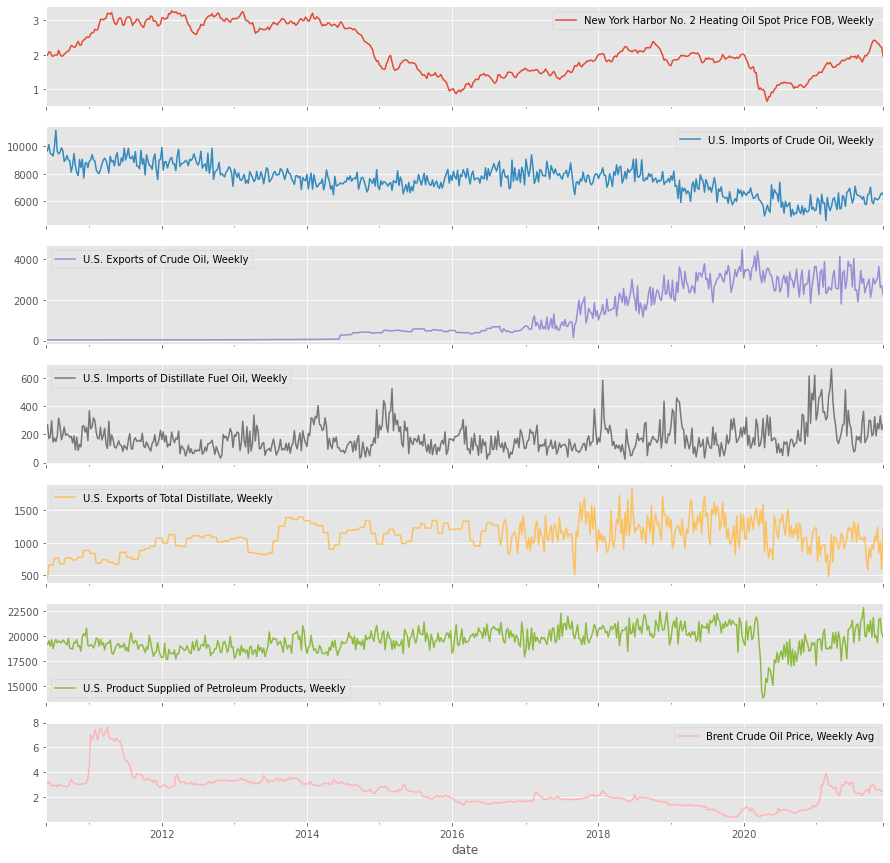

In [82]:
_=df.plot(subplots = True,legend = True, figsize = (15,15))

## Examine Data for Granger Causality

In [98]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, ccf, pacf

y = df.columns[0]
X = df.columns[1:]
for x in X:
    
    # The data for test whether the time series in the second column
    # Granger causes the time series in the first column.

    print('='*50)
    print(f'{x}')
    print('='*50)
    print('Granger Test Results')
    u = grangercausalitytests(df[[y,x]].values,maxlag=16)    

U.S. Imports of Crude Oil, Weekly
CCF Max Score: 0.5580246640555486, Lag: 32
Granger Test Results

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7644  , p=0.0969  , df_denom=597, df_num=1
ssr based chi2 test:   chi2=2.7783  , p=0.0955  , df=1
likelihood ratio test: chi2=2.7719  , p=0.0959  , df=1
parameter F test:         F=2.7644  , p=0.0969  , df_denom=597, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7645  , p=0.1722  , df_denom=594, df_num=2
ssr based chi2 test:   chi2=3.5588  , p=0.1687  , df=2
likelihood ratio test: chi2=3.5483  , p=0.1696  , df=2
parameter F test:         F=1.7645  , p=0.1722  , df_denom=594, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9934  , p=0.3954  , df_denom=591, df_num=3
ssr based chi2 test:   chi2=3.0156  , p=0.3892  , df=3
likelihood ratio test: chi2=3.0080  , p=0.3904  , df=3
parameter F test:         F=0.9934  , p=0.3954  , df_denom=591, df_nu

ssr based F test:         F=8.9674  , p=0.0029  , df_denom=597, df_num=1
ssr based chi2 test:   chi2=9.0125  , p=0.0027  , df=1
likelihood ratio test: chi2=8.9455  , p=0.0028  , df=1
parameter F test:         F=8.9674  , p=0.0029  , df_denom=597, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1273  , p=0.0446  , df_denom=594, df_num=2
ssr based chi2 test:   chi2=6.3073  , p=0.0427  , df=2
likelihood ratio test: chi2=6.2743  , p=0.0434  , df=2
parameter F test:         F=3.1273  , p=0.0446  , df_denom=594, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3127  , p=0.0750  , df_denom=591, df_num=3
ssr based chi2 test:   chi2=7.0203  , p=0.0713  , df=3
likelihood ratio test: chi2=6.9794  , p=0.0726  , df=3
parameter F test:         F=2.3127  , p=0.0750  , df_denom=591, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8699  , p=0.1142  , df_denom=588, df_num=4
ssr based chi2 test: 

likelihood ratio test: chi2=4.6361  , p=0.9475  , df=11
parameter F test:         F=0.4066  , p=0.9533  , df_denom=567, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.4504  , p=0.9422  , df_denom=564, df_num=12
ssr based chi2 test:   chi2=5.6448  , p=0.9329  , df=12
likelihood ratio test: chi2=5.6179  , p=0.9341  , df=12
parameter F test:         F=0.4504  , p=0.9422  , df_denom=564, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=0.4185  , p=0.9634  , df_denom=561, df_num=13
ssr based chi2 test:   chi2=5.7027  , p=0.9563  , df=13
likelihood ratio test: chi2=5.6752  , p=0.9572  , df=13
parameter F test:         F=0.4185  , p=0.9634  , df_denom=561, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=0.3888  , p=0.9780  , df_denom=558, df_num=14
ssr based chi2 test:   chi2=5.7268  , p=0.9729  , df=14
likelihood ratio test: chi2=5.6991  , p=0.9735  , df=14
parameter F test:      

## Decompose

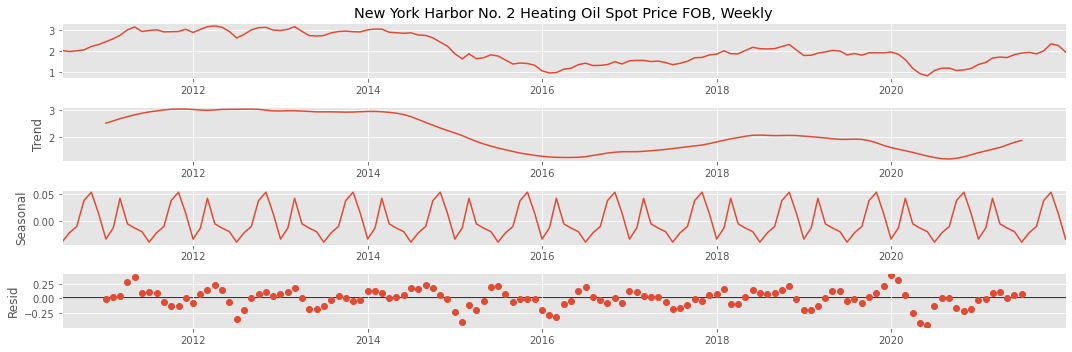

In [80]:
res = seasonal_decompose(df.resample('M').mean()[df.columns[0]],model='add')
_=res.plot()

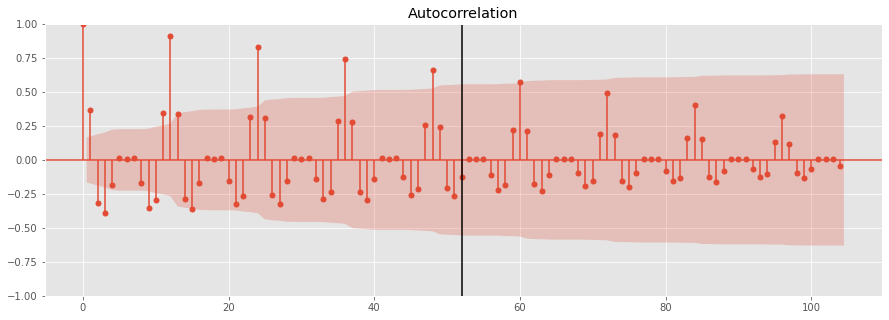

In [81]:
_=plot_acf(res.seasonal, lags=104)
_=plt.axvline(52,c='k')

## Test Train Split

In [22]:
split_idx = int(len(df)*0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]
print(f'Training Set Size {len(train_df)}')
print(f'Test Set Size {len(test_df)}')

Training Set Size 480
Test Set Size 121


## Try Prophet

In [10]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

model = Prophet()

In [14]:
ptrain_df = train_df.reset_index().rename(columns={'date':'ds','ppg':'y'})
model.fit(ptrain_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
p_forcast = model.predict(model.predict(model.make_future_dataframe(periods=162,freq='W-FRI')))

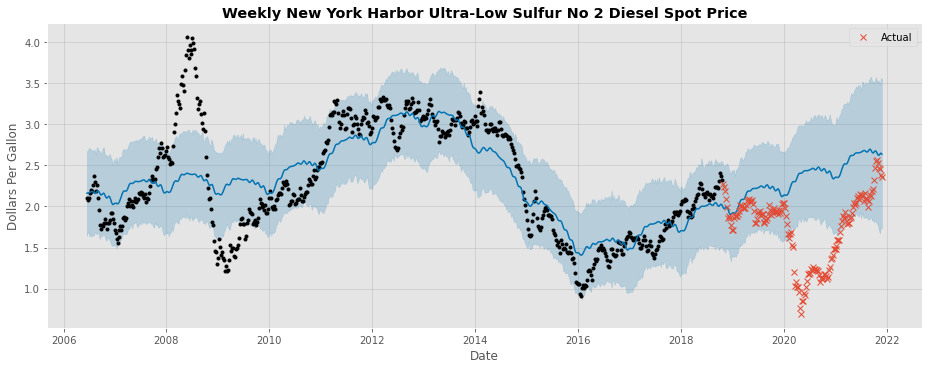

In [22]:
fig = model.plot(p_forcast,figsize=(13,5))
ax = fig.gca()
ax.plot(test_df.index,test_df.ppg,'x',label = 'Actual')
#ax.set_xlim(pd.to_datetime(['2008-01-01','2010-12-01']))
ax.legend(loc='best')
ax.set_title('Weekly New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price',
         fontweight='bold')
ax.set_ylabel('Dollars Per Gallon')
_=ax.set_xlabel('Date')